NLP

En este archivo creamos el modelo de analisis de sentimientos

Importamos las librerias necesarias

In [7]:
import pandas as pd
import random
import os
import numpy as np
import joblib
import re
from nltk.stem import WordNetLemmatizer
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import nltk
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
"""nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')"""

"nltk.download('averaged_perceptron_tagger')\nnltk.download('wordnet')\nnltk.download('punkt')\nnltk.download('stopwords')"

Obtener ruta actual, nos servira para cargar y guardar los archivos

In [8]:
# Obtener la ruta de las reviews
ruta_reviews = r'C:\PROYECTO-INDIVIDUAL\Data\parquet\reviews.parquet'

Abrimos el archivo

In [9]:
df = pd.read_parquet(ruta_reviews)

Creamos las stopwords y el filtro

In [10]:
stopwords_ingles = nltk.corpus.stopwords.words('english')
stopwords_spanish = nltk.corpus.stopwords.words('spanish')
stopwords_russian = nltk.corpus.stopwords.words('russian')
stopwords_portuguese = nltk.corpus.stopwords.words('portuguese')
stopwords = stopwords_ingles + stopwords_spanish + stopwords_russian + stopwords_portuguese
filtrar = []
if True:
    filtrar.append('game')
    filtrar.append('play')
    filtrar.append('games')
    filtrar.append('playing')

Creamos un df con las recomendaciones negativas

In [11]:
df_no_recomendado = df[df['recommend']==0]

In [12]:
df_si_recomendado = df[df['recommend']==2]

Creamos un df con las recomendaciones neutras

In [13]:
df_neutras = df[df['recommend']==1]

Creamos de manera sintetica algunas recomendaciones neutras combinando recomendaciones buenas y malas

In [14]:
num_neutras = min(len(df_si_recomendado), len(df_no_recomendado))
neutras = []
for _ in range(num_neutras):
    buena = random.choice(df_si_recomendado['review'].values)
    mala = random.choice(df_no_recomendado['review'].values)
    neutra = buena + mala
    neutras.append(neutra)


Creamos un df que guarde esas reviews sinteticas y lo concatenamos con el df_neutras

In [15]:
df_neutras_combinadas = pd.DataFrame({'review': neutras, 'recommend': [1]*len(neutras)})
df_neutras_combinadas = pd.concat([df_neutras_combinadas, df_neutras], ignore_index=True)
df_neutras_combinadas.head()

,review,recommend,user_id,item_id
0,"Dark Souls, an infamous game of death and lea...",1,NaN,NaN
1,"Not the worlds best game by far, but good eno...",1,NaN,NaN
2,pretty good cant play properly because everyt...,1,NaN,NaN
3,Muito bom ♥♥♥♥♥!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,1,NaN,NaN
4,Much MLG... Much WOW... Much Revolvo... Much ...,1,NaN,NaN


Creamos una lista de tokens a partir de las recomendaciones neutras

In [16]:
tokens_neutros = []
tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")
for review in df_neutras_combinadas['review']:
    if isinstance(review, str):  # Verificar si es una cadena de texto
        words = tokenizer.tokenize(review)
        words = [word for word in words if word.lower() not in stopwords]
        words = [word for word in words if word not in filtrar and len(word) >= 3]
        tokens_neutros.append(words)
    else:
        tokens_neutros.append([])

Vemos cuales son algunos de los tokens que aparecen

In [17]:
tokens_neutros = list(itertools.chain(*tokens_neutros))
tokens_neutros[0:10]

['Dark',
 'Souls',
 'infamous',
 'death',
 'learning',
 'sure',
 'havent',
 'finished',
 'really',
 'enjoy']

Vemos cuales son los mas comunes

In [18]:
frecuencia_neutral = nltk.FreqDist(tokens_neutros)
frecuencia_neutral

FreqDist({'like': 2604, 'get': 2475, 'good': 2066, 'fun': 2038, 'HAT': 2004, 'one': 1580, 'would': 1562, 'time': 1525, 'really': 1517, 'bad': 1517, ...})

Creamos un df a partir de ello

In [19]:
df_rec_neutras = pd.DataFrame(list(frecuencia_neutral.items()), columns= ['Word', 'Frequency'])
df_rec_neutras.head()

,Word,Frequency
0,Dark,36
1,Souls,16
2,infamous,2
3,death,117
4,learning,45


Lo ordenamos por frecuencia

In [20]:
df_rec_neutras.sort_values('Frequency', ascending=False, inplace=True)
df_rec_neutras.head()

,Word,Frequency
12,like,2604
87,get,2475
35,good,2066
96,fun,2038
15265,HAT,2004


Reseteamos el indice

In [21]:
df_rec_neutras.reset_index(drop=True, inplace=True)
df_rec_neutras.head(10)

,Word,Frequency
0,like,2604
1,get,2475
2,good,2066
3,fun,2038
4,HAT,2004
5,one,1580
6,would,1562
7,time,1525
8,bad,1517
9,really,1517


Vemos de forma grafica los tokens y su frecuencia

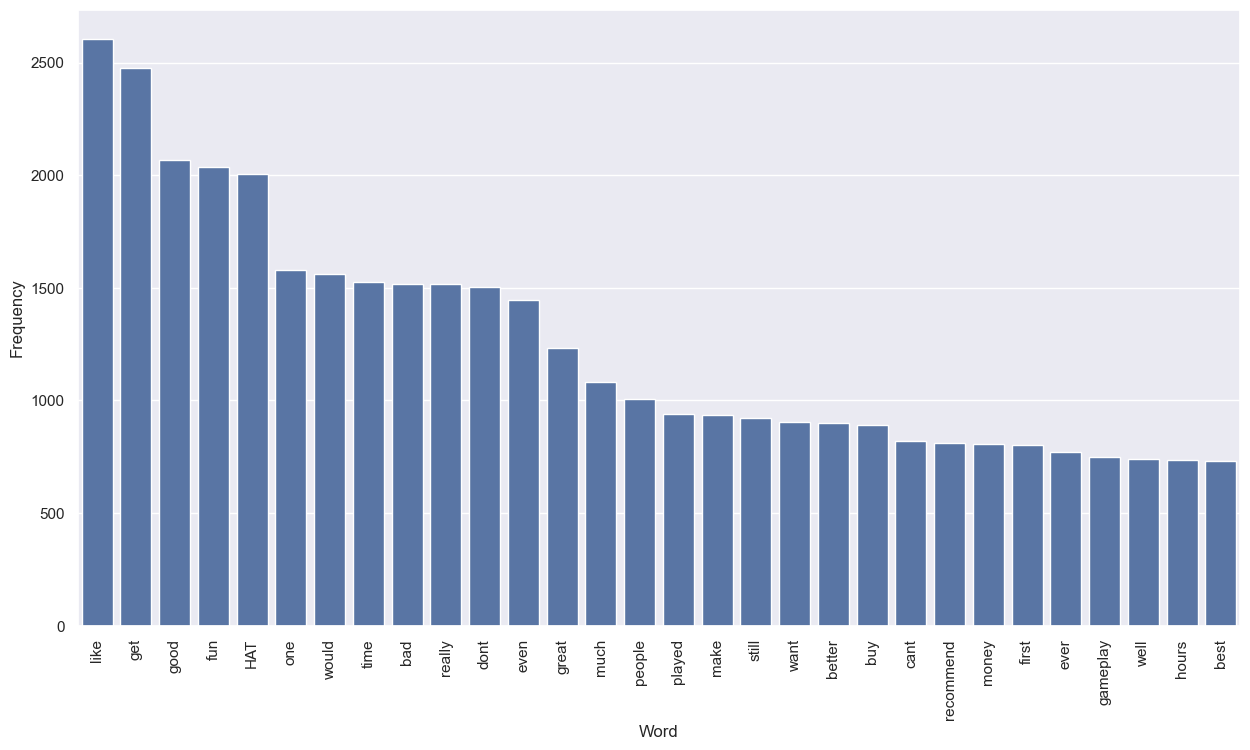

In [22]:
plt.figure(figsize=(15,8))
plot = sns.barplot(x = df_rec_neutras.iloc[:30].Word, y = df_rec_neutras.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

Creamos un df que contenga el df original mas las reviews neutras

In [23]:
df_balanceado = pd.concat([df, df_neutras_combinadas], ignore_index=True)
df_balanceado.head()

,user_id,item_id,recommend,review
0,76561197970982479,1250.0,2,Simple yet with great replayability. In my op...
1,76561197970982479,22200.0,2,Its unique and worth a playthrough.
2,76561197970982479,43110.0,2,Great atmosphere. The gunplay can be a bit ch...
3,js41637,251610.0,2,I know what you think when you see this title...
4,js41637,227300.0,2,For a simple (its actually not all that simpl...


Mantenemos la review y el puntaje

In [24]:
df_balanceado = pd.concat([df_balanceado.review, df_balanceado.recommend], axis=1)
df.head()

,user_id,item_id,recommend,review
0,76561197970982479,1250,2,Simple yet with great replayability. In my op...
1,76561197970982479,22200,2,Its unique and worth a playthrough.
2,76561197970982479,43110,2,Great atmosphere. The gunplay can be a bit ch...
3,js41637,251610,2,I know what you think when you see this title...
4,js41637,227300,2,For a simple (its actually not all that simpl...


Creamos un diccionario con las tags de las clases de palabras que usaremos al lematizar

In [25]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

Instanciamos un objeto wordnetlemmatizer

In [26]:
wordnet_lemmatizer = WordNetLemmatizer()

Creamos una lista de recomendaciones lematizadas

In [27]:
recomendaciones_lemm = []
for recomendacion in df_balanceado.review:
    recomendacion = re.sub("[^a-zA-Z]"," ",str(recomendacion))
    recomendacion = recomendacion.lower()
    recomendacion = nltk.word_tokenize(recomendacion)
    recomendacion = [palabra for palabra in recomendacion if len(palabra)>2]
    recomendacion = [palabra for palabra in recomendacion if not palabra in stopwords]
    recomendacion = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in recomendacion]
    recomendacion = " ".join(recomendacion)
    recomendaciones_lemm.append(recomendacion)

Creamos una columna con las reviews lematizadas

In [28]:
df_balanceado['review_lemm'] = recomendaciones_lemm
df.tail(5)

,user_id,item_id,recommend,review
59300,76561198312638244,70,2,a must have classic from steam definitely wor...
59301,76561198312638244,362890,2,this game is a perfect remake of the original...
59302,LydiaMorley,273110,2,had so much fun plaing this and collecting re...
59303,LydiaMorley,730,2,:D
59304,LydiaMorley,440,2,so much fun :D


Creamos un df con las reviews lematizadas y el puntaje

In [29]:
df_lem = pd.concat([df_balanceado.review_lemm, df_balanceado.recommend], axis=1)
df_lem.head()

,review_lemm,recommend
0,simple yet great replayability opinion zombie ...,2
1,unique worth playthrough,2
2,great atmosphere gunplay bit chunky time end d...,2
3,know think see title barbie dreamhouse party i...,2
4,simple actually simple truck drive simulator q...,2


Rellenamos los string 'vacios' con vacio y luego reemplazamos los vacios con 1. Todo esto por si surgio algun otro vacio

In [30]:
df_lem['review_lemm'] = df_lem['review_lemm'].fillna('vacio')
df_lem['recommend'] = df_lem['recommend'].fillna(1)

Creamos una lista con los valores de las recomendaciones y otra con los valores de los puntajes

In [31]:
lista_recomendaciones = list(df_lem['review_lemm'].values)
es_recommend = df_lem['recommend'].values

Asignamos el max_features

In [32]:
max_features = 3000

Creamos el vectorizador

In [33]:
cou_vec = CountVectorizer(max_features=max_features, stop_words="english", ngram_range=(1,2))

Creamos una matriz con la lista de recomendaciones de manera vectorizada

In [34]:
matriz_reviews = cou_vec.fit_transform(lista_recomendaciones)

Creamos una lista con las 3000 palabras mas comunes

In [35]:
las_palabras = cou_vec.get_feature_names_out()
las_palabras[0:50]

array(['abandon', 'ability', 'abit', 'able', 'able play', 'absolute',
       'absolutely', 'absolutely amaze', 'absolutely love', 'access',
       'access game', 'account', 'accurate', 'ace', 'achieve',
       'achievement', 'act', 'action', 'action game', 'action packed',
       'active', 'actual', 'actually', 'actually play', 'add', 'add game',
       'add new', 'add overprice', 'addict', 'addict game', 'addictive',
       'addictive game', 'addition', 'additional', 'addons', 'address',
       'admit', 'adult', 'advance', 'advanced', 'advantage', 'adventure',
       'adventure game', 'advice', 'aesthetic', 'affect', 'afford', 'age',
       'ago', 'agora'], dtype=object)

Transformamos en array la matriz

In [36]:
x = matriz_reviews.toarray()

Asignamos la lista de puntajes a y

In [37]:
y = es_recommend

Dividimos en segmento de entrenamiento y de testeo

In [38]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

Creamos una matriz de confusion

In [39]:
def confusion(ytest,y_pred):
    names = ['Recomendado', 'No recomendado', 'Neutral']
    cm = confusion_matrix(ytest,y_pred)
    f, ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm, annot=True, linewidths=.5, linecolor='r', fmt='.0f', ax=ax)
    plt.xlabel('y_pred')
    plt.ylabel('y_true')
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

Aplicamos el modelo SVC LINEAL, lo entrenamos y testeamos, con ello evaluamos su precision

In [40]:
svc = LinearSVC(C = 1)
svc.fit(xtrain,ytrain)
svc.score(xtest,ytest)

c:\Users\augus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\augus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8145600241911097

Graficamos la matriz de confusion

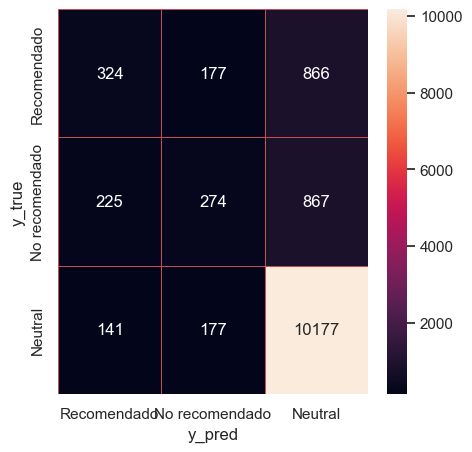

In [41]:
y_pred = svc.predict(xtest)
confusion(ytest,y_pred)

Para asignar entre las 3 categorias, 2 = Bueno, 1 = Neutral y 0 = Malo, nos basaremos en la probabilidad que tiene una review de ser buena

In [42]:
# Predicción de probabilidades para las clases
y_prob = svc.decision_function(xtest)
print(y_prob[1])

[-1.51062807 -1.02673167  0.87306542]


Definimos los umbrales, Malo<0.5<Neutral<0.7<Bueno

In [43]:
umbral_malo = 0.5
umbral_neutral = 0.7

Comparamos las probabilidades con los umbrales

In [44]:
# Comparar cada probabilidad con los umbrales utilizando broadcasting de numpy
y_pred = np.where(y_prob <= umbral_malo, 0, np.where(y_prob <= umbral_neutral, 1, 2))

Convertir las predicciones en una clase, basado en los umbrales

In [45]:
# Convertir las predicciones a una clase según umbrales
y_pred_class = []
for pred in y_pred:
    if pred[2] == max(pred):  # Si la mayor probabilidad es para la clase 2 (buena)
        y_pred_class.append(2)  # Clasificar como buena
    elif pred[0] == max(pred):  # Si la mayor probabilidad es para la clase 0 (mala)
        y_pred_class.append(0)  # Clasificar como mala
    else:  # Si la mayor probabilidad es para la clase 1 (neutral)
        y_pred_class.append(1)  # Clasificar como neutral

Reporte de clasificacion, una vez aplicado el metodo de probabilidad

In [46]:
# Reporte de clasificación
print(classification_report(ytest, y_pred_class))

              precision    recall  f1-score   support

           0       0.51      0.08      0.14      1367
           1       0.43      0.04      0.07      1366
           2       0.81      0.99      0.89     10495

    accuracy                           0.80     13228
   macro avg       0.58      0.37      0.37     13228
weighted avg       0.74      0.80      0.73     13228



Graficamos la matriz de confusion

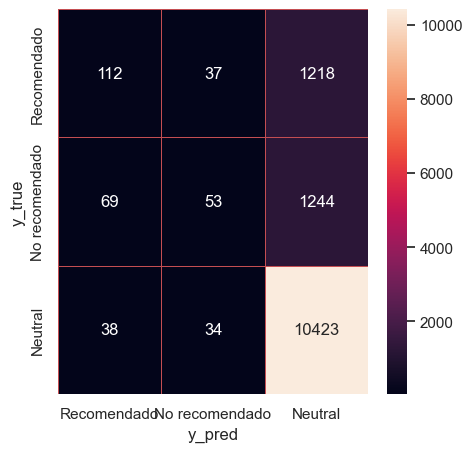

In [47]:
confusion(ytest,y_pred_class)

Como vemos la precision de nuestro modelo, basado en la probabilidad es de un 0.80

Ahora guardamos el modelo, para ello creamos una carpeta llamada modelos

In [48]:
ruta_guardar_modelo = r'C:\PROYECTO-INDIVIDUAL\Sentiment_analysis\modelo\NPL_SVC.pkl'

# Guardar el modelo en un archivo
joblib.dump(svc, ruta_guardar_modelo)

['C:\\PROYECTO-INDIVIDUAL\\Sentiment_analysis\\modelo\\NPL_SVC.pkl']